In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

import nltk
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from IPython.display import display

In [88]:
# !pip install joblib scikit-learn


# Load Data and Perform Data Filtering and Transformation

In [14]:
file_path = r'../data/final_data.csv'
df = pd.read_csv(file_path, encoding='utf-8')

# Cleaning columns ans filtering "Birth Control"
filtered_df = df[df['condition'] == 'Birth Control'].drop(
    columns=['Unnamed: 0', 'condition', 'date', 'usefulCount', 'matched_generic_name', 'matched_type']
)

filtered_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/final_data.csv'

In [15]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28788 entries, 0 to 31250
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   provided_drug_name  28788 non-null  object
 1   review              28788 non-null  object
 2   rating              28788 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 899.6+ KB


In [16]:
filtered_df.rename(columns= {"provided_drug_name":"drugname"}, inplace= True)

# Labeling Function and Target Distribution Analysis

In [18]:
#label  pos and neg

def label_rating(rating):
    if rating <= 5:
        return 'Negative'
    else:
        return 'Positive'

In [19]:
filtered_df['target'] = filtered_df['rating'].apply(label_rating)
filtered_df.head()

,drugname,review,rating,target
0,Lybrel,"""I used to take another oral contraceptive, wh...",5,Negative
1,Ortho Evra,"""This is my first time using any form of birth...",8,Positive
3,Ethinyl estradiol / levonorgestrel,"""I had been on the pill for many years. When m...",8,Positive
4,Nexplanon,"""Started Nexplanon 2 months ago because I have...",3,Negative
5,Etonogestrel,"""Nexplanon does its job. I can have worry free...",9,Positive


In [20]:
filtered_df.isnull().sum()

drugname    0
review      0
rating      0
target      0
dtype: int64

In [21]:
pd.set_option('display.max_colwidth', None)

In [22]:
#Check out target distribution

target_distr = filtered_df["target"].value_counts()
target_distr*100/len(filtered_df)

# 57% of the ratings are "Positive" and  43% are "Negative". A bit imbalanced dataset


target
Positive    57.444074
Negative    42.555926
Name: count, dtype: float64

# Preprocessing Steps

In [23]:
# Seeing what reviews looks like
text = filtered_df.review.iloc[1]
print(text)

"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"


In [24]:
# Def RegEx

REPLACE_NO_SPACE = re.compile(r"[.;:!#\'?,\"()\[\]&]|\d+")  # delete punctuation and numbers
REPLACE_WITH_SPACE = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)") 

# We want to remove everything that is not a proper character. RegEx for non-alphanumerical characters.

In [25]:
#Preprocess function for "review" column

stop_words = set(stopwords.words('english'))

def preprocess_review(reviews):

    # Remove special characters
    reviews = re.sub(REPLACE_NO_SPACE, "", reviews)  #aqui tambien podemos usar RegexpTokenizer()
    reviews = re.sub(REPLACE_WITH_SPACE, " ", reviews)

    tokens = word_tokenize(reviews)

    # Lowercase and lemmatize
    lemmatizer = WordNetLemmatizer()

    lemmas = [lemmatizer.lemmatize(token.lower(), pos='v') for token in tokens if token.lower() not in stop_words]
    lemmas = [lemmatizer.lemmatize(token.lower(), pos='n') for token in lemmas if token.lower() not in stop_words]


    return lemmas


### Sanity check ____________________________________________________________________________________________________________________________________________________________________________


In [26]:
start = text.find("of birth control. I&#039;m glad I went with")
end = start + len("of birth control. I&#039;m glad I went with")
print(f"Start position: {start}")
print(f"End position: {end}")
text = filtered_df['review'][1][38:81]
print(text)

preprocess_review(text)

Start position: 38
End position: 81
of birth control. I&#039;m glad I went with


['birth', 'control', 'im', 'glad', 'go']


____________________________________________________________________________________________________________________________________________________________________________

# Splitting the Data into Training and Test Sets

In [27]:
# X = independent variable = review,  y = target variable (dependent) = rating

X = filtered_df['review']
y= filtered_df['target']

# why we are doing these? video: 1:20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("DataFrame dimensions:", filtered_df.shape)
print(f"Train dimensions: {X_train.shape, y_train.shape}")  
print(f"Test dimensions: {X_test.shape, y_test.shape}")  

DataFrame dimensions: (28788, 4)
Train dimensions: ((23030,), (23030,))
Test dimensions: ((5758,), (5758,))


In [29]:
# Check the distribution of classes in the training and testing sets

print(y_train.value_counts())
print(y_test.value_counts())

# Both has the same proportion, 74% --> stratified

target
Positive    13232
Negative     9798
Name: count, dtype: int64
target
Positive    3305
Negative    2453
Name: count, dtype: int64


In [30]:
X_train.head()

26256                                                     "I switched to this pill after using Sprintec for years and had instant weight gain. I gained 20 pounds in the first three months. No noticeable changes in mood, sex drive, or acne. My skin stayed very clear. I also stopped having a period completely and although it was wonderful I could not get used to it. The pregnancy panics along with the weight gain forced me to stop taking these pills."
22909                                         "I&#039;ve had it for 2 weeks so far no side effects yay!!! I don&#039;t get why people keep it in for years if it has crazy side effects like weight gain, suicide etc? The moment I gain 5 lbs I&#039;m getting it out. I have a very very regular workout and diet schd. The only pills that worked for me we&#039;re Yasmin and mini pill but I kept forgetting to take it after my sons birth hence the implanon."
17874                                                                                       

# Vectorizing: Choosing the Right Weighting Scheme

In [31]:
#What is my weighting scheme? in this case, Tfidf beacuse...

vectoriser = TfidfVectorizer(analyzer=preprocess_review)
X_train_tfidf = vectoriser.fit_transform(X_train)

In [32]:
X_train_tfidf.shape # --> representación de una Bag of Words (BoW)

# had in mind: 
# DataFrame dimensions: (31251, 3)
# Train dimensions: ((23030,), (23030,))
# # Test dimensions: ((5758,), (5758,))

# X_train_tfidf es una matriz donde cada fila representa un documento y cada columna representa una palabra (o término)
# en el vocabulario que fue creado a partir de los documentos de entrenamiento.
# Cada entrada en esta matriz corresponde a la importancia de la palabra en el documento, medida por el TF-IDF.

(23030, 11644)

In [33]:
#represent test documents in the Vector Space we've learned with the train documents
X_test_tfidf = vectoriser.transform(X_test)

In [34]:
X_test_tfidf.shape 

(5758, 11644)

nlp done

# Train Classifiers: Naive Bayes and Others

In [35]:
# Fit the model using training data
# The text information now is structured and weighted according to TF-IDF
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train) #y_train are my labels

# X_train_tfidf -> contiene las características (entrada) 
# y_train -> contiene las etiquetas (salida esperada)

MultinomialNB()

In [36]:
#y_train.head()

# Model Performance: How Well Does It Perform?

 **y_test** -> true labels 
 **nb.predict(X_test_tfidf)** -> The labels predicted by the model ()).

 **Accuracy** --> 
 - It returns a value between 0 and 1 
 - Represents the proportion of correct predictions relative to the total predictions

In [37]:
average_method = 'weighted'  # Should I use 'macro' or 'micro'?

# Choose micro when you want a global view of your model’s performance.
# Choose macro when you want to treat all classes equally, irrespective of their sizes.
# Choose weighted when dealing with imbalanced classes, as it takes class sizes into account.

# print(f'Accuracy: {accuracy_score(y_test, nb.predict(X_test_tfidf)):.2f}')  #REMOVE?
print(f'F1 Score: {f1_score(y_test, nb.predict(X_test_tfidf), average=average_method):.2f}')
print(f'Precision: {precision_score(y_test, nb.predict(X_test_tfidf), average=average_method):.2f}')
print(f'Recall: {recall_score(y_test, nb.predict(X_test_tfidf), average=average_method):.2f}')

# print(f'ROC AUC: {roc_auc_score(y_test, nb.predict_proba(X_test_tfidf)):.2f}')


F1 Score: 0.79
Precision: 0.81
Recall: 0.79


**Notes**:
average='weighted':
 This parameter is used to compute the metrics for multi-class classification. It accounts for the proportion of each class in the dataset. can change it based on  specific needs (e.g., average='macro' or average='micro').
Given that whe have a binary classification problem with a slight class imbalance (57% positive and 43% negative reviews), we select the next evaluation metrics for our model:

**Precision**: is the proportion of true positive predictions among all positive predictions.

In our context, precision will tell us how many of the reviews predicted as positive are actually positive. High precision means fewer false positives, which is important if you want to ensure that positive reviews are indeed seen as such.

**Recall** (Sensitivity): proportion of true positive predictions among all actual positives. TP/P

Will show how well our model identifies actual positive reviews. In a review context, high recall means that most positive reviews are correctly identified.

**F1 Score**  (Relates precision and recall)

The F1 score is particularly useful for balancing precision and recall, especially when have a slight imbalance. It gives a single score to evaluate your model’s performance, which is beneficial when want to optimize both false positives and false negatives.

As an additional metric: **ROC-AUC**  Measures the model’s ability to distinguish between the positive and negative classes across all thresholds.
Importance:  provides insights into how well your model performs across different thresholds, giving a broader view of its performance regardless of class imbalance.

Why do not use accuracy --< While accuracy can provide a general sense of how well the model performs, it's not the best metric for imbalanced datasets. Since we have a slight imbalance, it might give a misleading impression of model performance, especially if the model predicts the majority class more often.
>

## add a confusion matrix?

# Wrap-Up: Running the Models Using the Pipeline


## Pipeline: Logistic Regression

In [90]:
import joblib 

In [38]:
from sklearn.linear_model import LogisticRegression

# vectoriser = TfidfVectorizer(analyzer=preprocess_review)
# lr = LogisticRegression()

# pipe_lr = Pipeline([
#     ('vectorizer', vectoriser), 
#     ('classifier', lr)
# ])


# pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function preprocess_review at 0x000001E74FE039C0>)),
                ('classifier', LogisticRegression())])

In [91]:
# Guardar el pipeline de lr
joblib.dump(pipe_lr, 'pipe_lr.pkl')

# Load  pipeline 
loaded_pipe_lr = joblib.load('pipe_lr.pkl')

In [39]:
y_test_pred_lr = loaded_pipe_lr.predict(X_test)

## Logistic Regression Performance


In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [48]:
# Reporte de clasificación
print(classification_report(y_test, y_test_pred_lr))


              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      2453
    Positive       0.85      0.87      0.86      3305

    accuracy                           0.84      5758
   macro avg       0.84      0.83      0.83      5758
weighted avg       0.84      0.84      0.84      5758



In [56]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred_lr)
cm

# [[TN, FP],
#  [FN, TP]]


array([[1966,  487],
       [ 442, 2863]], dtype=int64)

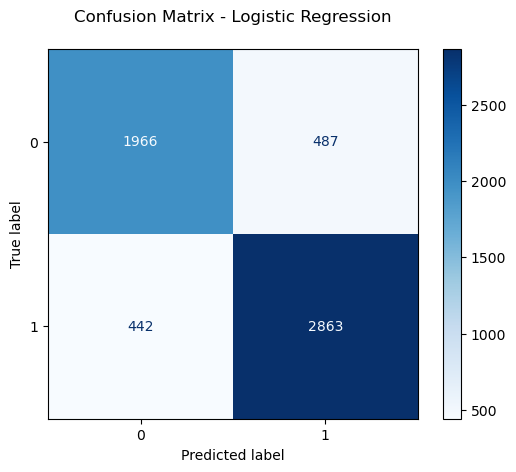

In [82]:
#Matriz de confusión
confusion_matrix_lr = ConfusionMatrixDisplay(cm)
confusion_matrix_lr.plot(cmap='Blues', colorbar=True)
plt.title('Confusion Matrix - Logistic Regression', pad=20)
plt.show()


## Pipeline: Naive-Bayes

In [93]:
vectoriser = TfidfVectorizer(analyzer=preprocess_review)
# nb= MultinomialNB()

# pipe_nb = Pipeline([
#     ('vectoriser', vectoriser),
#     ('classifier', nb)
# ])

# pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(analyzer=<function preprocess_review at 0x000001E74FE039C0>)),
                ('classifier', MultinomialNB())])

In [95]:
# Saving pipeline de nb
joblib.dump(pipe_nb, 'pipe_nb.pkl')

# Load  pipeline 
loaded_pipe_nb = joblib.load('pipe_nb.pkl')

In [96]:
y_test_pred_nb = loaded_pipe_nb.predict(X_test)

dudas: pipe.fit(), pipe.transform(), pipe.predict(), pipe.fit_transform()

## Naive-Bayes Performance

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

# Reporte de clasificación
print(classification_report(y_test, y_test_pred_nb))

# # Matriz de confusión
# cm = confusion_matrix(y_test, y_test_pred_nb)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

              precision    recall  f1-score   support

    Negative       0.89      0.59      0.71      2453
    Positive       0.76      0.94      0.84      3305

    accuracy                           0.79      5758
   macro avg       0.82      0.77      0.78      5758
weighted avg       0.81      0.79      0.79      5758



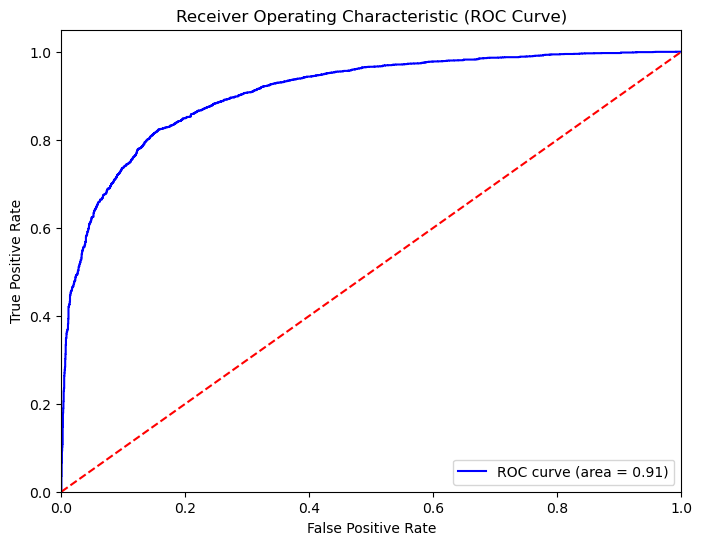

In [79]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convertir las etiquetas de texto a numéricas
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # Esto convierte 'Negative' a 0 y 'Positive' a 1

# Obtener las probabilidades de las predicciones para la clase positiva
y_probs = pipe_nb.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Calcular las tasas de verdaderos positivos y falsos positivos
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_probs)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia (modelo aleatorio)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend(loc='lower right')
plt.show()



¡Entiendo! Entonces, tu modelo está diseñado para clasificar las reseñas de anticonceptivos como positivas o negativas. 

- **True Positive Rate (TPR)**: En tu caso, esto representa la proporción de **reseñas** positivas correctamente identificadas como positivas por el **modelo**.
- **False Positive Rate (FPR)**: Esto representa la proporción de **reseñas** negativas **incorrectamente** identificadas como **positivas**.

La **Curva ROC** muestra cómo varía el rendimiento del modelo a diferentes umbrales de clasificación. Un **AUC de 0.91** indica que tu modelo tiene una alta capacidad para distinguir entre reseñas positivas y negativas. Cuanto más cerca esté la curva de la esquina superior izquierda, mejor es el rendimiento del modelo.

En resumen, tu modelo es bastante efectivo para clasificar las reseñas de anticonceptivos en positivas y negativas, lo cual es crucial para entender la percepción de los usuarios sobre estos productos.

Curva ROC: Es un gráfico que muestra el rendimiento de un modelo de clasificación en diferentes umbrales. Te ayuda a visualizar cómo el modelo equilibra los verdaderos positivos y los falsos positivos.
AUC (Área Bajo la Curva): Es un solo número que resume el rendimiento de la Curva ROC. Cuanto más alto sea el AUC, mejor es el modelo para distinguir entre las clases positivas y negativas.


¿Qué pasa si la curva está cerca de la diagonal? Entonces, si la curva está cerca de la diagonal, necesitaríamos mejorar el modelo para que pueda hacer mejores predicciones.




El número 0.91 es el área bajo la curva (AUC). Este número nos dice que nuestro modelo es muy bueno (91% de precisión) en diferenciar entre reseñas positivas y negativas.

¿Te gustaría profundizar en algún aspecto específico de la curva o del rendimiento del modelo?

## Pipeline: Random Forest Model

In [98]:
# # Wrap Up Random Forest
# vectoriser = TfidfVectorizer(analyzer=preprocess_review)
# rf= RandomForestClassifier()

# pipe_rf = Pipeline([('vectoriser', vectoriser),
#                  ('classifier', rf)])

# pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(analyzer=<function preprocess_review at 0x000001E74FE039C0>)),
                ('classifier', RandomForestClassifier())])

In [99]:
joblib.dump(pipe_rf, 'pipe_rf.pkl')

loaded_pipe_rf = joblib.load('pipe_rf.pkl')

In [100]:
y_test_pred_rf = pipe_rf.predict(X_test)

## Random Forest Performance

In [102]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_test_pred_rf))



              precision    recall  f1-score   support

    Negative       0.93      0.87      0.90      2453
    Positive       0.91      0.95      0.93      3305

    accuracy                           0.92      5758
   macro avg       0.92      0.91      0.92      5758
weighted avg       0.92      0.92      0.92      5758



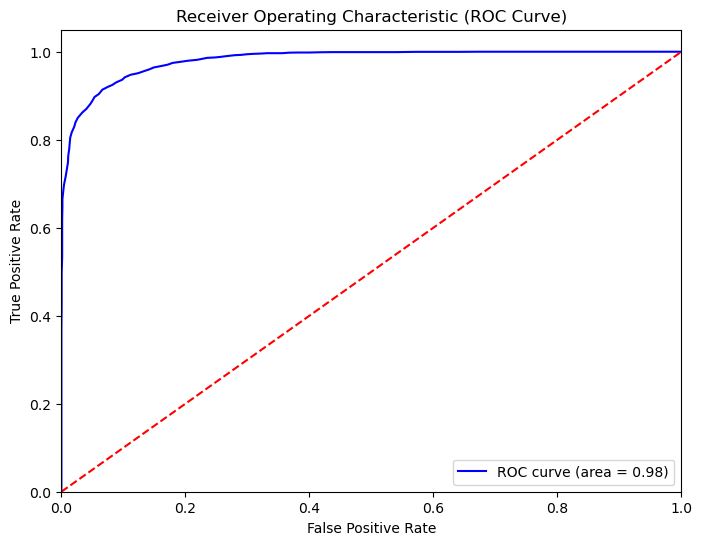

In [83]:
# Convertir las etiquetas de texto a numéricas
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # Esto convierte 'Negative' a 0 y 'Positive' a 1

# Obtener las probabilidades de las predicciones para la clase positiva
y_probs_rf= pipe_rf.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Calcular las tasas de verdaderos positivos y falsos positivos
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_probs_rf)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia (modelo aleatorio)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Convertir las etiquetas de texto a numéricas
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # Esto convierte 'Negative' a 0 y 'Positive' a 1

# Obtener las probabilidades de las predicciones para la clase positiva
y_probs = pipe_nb.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Calcular las tasas de verdaderos positivos y falsos positivos
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_probs)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia (modelo aleatorio)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend(loc='lower right')
plt.show()
